In [24]:
import os
from tqdm import tqdm

import torch as t
import torch.nn as nn
import torchvision
from torchvision import transforms

In [25]:
model = t.hub.load('pytorch/vision', 'resnet50', pretrained=True)
device = "cuda" if t.cuda.is_available() else "cpu"

Using cache found in /home/hice1/apanda38/.cache/torch/hub/pytorch_vision_main
/home/hice1/apanda38/notebooks/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hice1/apanda38/notebooks/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
for name, param in model.named_parameters():
    if "bn" not in name:
        param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(512, 2)
)

In [27]:
batch_size = 32
num_workers = 6

base_dir = '/home/hice1/apanda38/notebooks/dogs-vs-cats'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=preprocess)
train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=preprocess)
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [28]:
model = model.to(device)
epochs = 12
optimizer = t.optim.AdamW(model.parameters())
loss_fn = t.nn.CrossEntropyLoss(reduction='sum')

for _ in range(epochs):
    n_total = 0
    train_loss = 0.0
    model.train()
    for i, (x, y) in enumerate(tqdm(train_loader)):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        n_total += len(x)
    train_loss /= n_total

t.save(model, "resnet50_dog.pt")
train_loss

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.10it/s]


0.0102930079779578

In [29]:
model.eval()
with t.inference_mode():
    n_total = 0
    n_correct = 0
    val_loss = 0.0
    for i, (x, y) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)
        with t.autocast(device):
            y_hat = model(x)
            val_loss += loss_fn(y_hat, y).item()
        n_correct += (y_hat.argmax(dim=-1) == y).sum().item()
        n_total += len(x)

print(f"Test accuracy: {n_correct} / {n_total} = {100 * n_correct / n_total:.2f}%")
print(f"Test loss: {val_loss / n_total}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:03<00:00, 72.25it/s]

Test accuracy: 8867 / 9000 = 98.52%
Test loss: 0.054702392644352386


In [32]:
from sklearn.metrics import f1_score, roc_auc_score

y_true = []
y_pred = []
y_score = []

model.eval()
with t.inference_mode():
    for i, (x, y) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)
        with t.autocast(device):
            y_hat = model(x)
            probs = y_hat.softmax(dim=-1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(y_hat.argmax(dim=-1).cpu().numpy())
        y_score.extend(probs[:, 1].cpu().numpy())

f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_score)

print(f"F1 Score: {f1:.4f}")
print(f"AUROC: {roc_auc:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:03<00:00, 73.92it/s]

F1 Score: 0.9853
AUROC: 0.9991


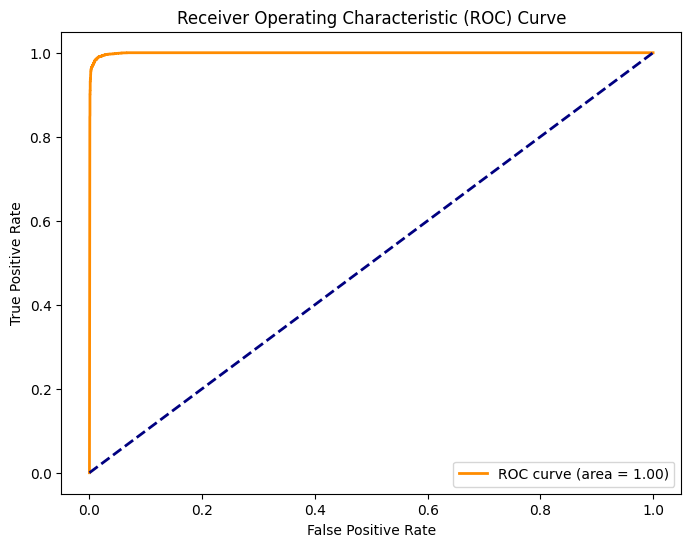

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()